In [1]:
#%matplotlib widget

# The potential of the electromagnetic induction method to monitor temperature changes in the near-surface

## Maria Carrizo, Dieter Werthmüller, and Evert Slob
Delft University of Technology, Faculty of Civil Engineering and Geosciences , Department of Applied Geophysics and Petrophysics, Delft, Netherlands (m.e.carrizomascarell@tudelft.nl)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from empymod import filters
import pygimli as pg
import matplotlib.tri as tri
from joblib import Parallel, delayed
import matplotlib
import copy
import sys
sys.path.insert(1, 'src')

# Load function that performs global search in lookup table
from EM1D import EMf_3Lay_HVP, GlobalSearch_3Lay, EMf_3Lay_Opt_HVP #ErrorSpace_3Lay

## EM Induction 

For the models data is simulated for an EMI device with the following characteristics
  - Frequency: 9000 Hz
  - Geometries: Horizontal coplanar (H) with offsets [2 m, 4 m, 8 m], Vertical coplanar (V) with offsets [2 m, 4 m, 8 m], and Perpendicular (P) with offsets [2.1 m, 4.1 m, 8.1 m]
  - Data obtained: vector with the Quadrature (Q) and In-phase (IP) components of the measurements for the H, V and P coil orientations: $d = [Q_{H2}, Q_{H4}, Q_{H8}, Q_{V2}, Q_{V4}, Q_{V8}, Q_{P2}, Q_{P4}, Q_{P8}, IP_{H2}, IP_{H4}, IP_{H8}, IP_{V2}, IP_{V4}, IP_{V8}, IP_{P2}, IP_{P4}, IP_{P8}]$

Assuming 3-layered EC models the model parameters would be a model $m$ vector:

\begin{equation}
    m = [\sigma_1, \sigma_2, \sigma_3, h_1, h_2],
\end{equation}

where $\sigma_1$ is the EC of the first layer, $\sigma_2$ is the electrical conductivity of the second layer, $\sigma_3$ is the electrical conductivity of the third layer, $h_1$ is the thickness of the first layer and $h_2$ is the thickness of the second layer

We use the method discussed in [Carrizo et. al., 2023](10.3997/2214-4609.202320049) to generate Lookup tables and perform a global search to estimate a 3-layered model.

The lookup table was generated using `1_LUTable3Lay.py` and stored in `Lookup_Tables/3Lay`. The global search will find the best data fit in the lookup table indicating the best fitting model.

In [3]:
# Settings for measurements simulations

# Define hankel filter
filt = filters.key_201_2012() 

# Define EMI instrument geometry
offsets = np.array([2, 4, 8]) # in meters
height = 0.10 # meters height from ground surface to center of coils
freq = 9000 # Frequency in Hz
# Lambda numbers
lambd = filt.base/offsets[:,np.newaxis] 

In [4]:
# number of cores used to perform the global search
n_workers=8

# Load conductivities and layer thicknesses sampled
conds = np.load('../GSplusOpt/Synth-3Layers/data/conds.npy')
thicks = np.load('../GSplusOpt/Synth-3Layers/data/thicks.npy')
nsl = len(conds) # number of samples

# Load lookup table
LU_3Lay = np.load('../GSplusOpt/Synth-3Layers/data/LUTable_3Lay.npy')

In [5]:
# Generate a 2 layered model and simulate EMI measurements

sigma_1 = 10/1000 # S/m
sigma_2 = 30/1000 # S/m
sigma_3 = 350/1000 # S/m
h1 = 2 # m
h2 = 2.4

model_3Lay_true =  ([sigma_1, sigma_2, sigma_3, h1,  h2])
data_3Lay_true = EMf_3Lay_HVP(lambd, 
                              sigma_1, 
                              sigma_2,
                              sigma_3,
                              h1, 
                              h2,
                              height, offsets, freq, filt)

In [6]:
# Perform inversion with global search

model_3Lay_est = GlobalSearch_3Lay(LU_3Lay, data_3Lay_true, conds, thicks, nsl)


In [8]:
data_3Lay_est = EMf_3Lay_HVP(lambd, 
                             sigma1 = model_3Lay_est[0],
                             sigma2 = model_3Lay_est[1],
                             sigma3 = model_3Lay_est[2],
                             h1 = model_3Lay_est[3],
                             h2 = model_3Lay_est[4],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

16/04/24 - 00:51:52 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


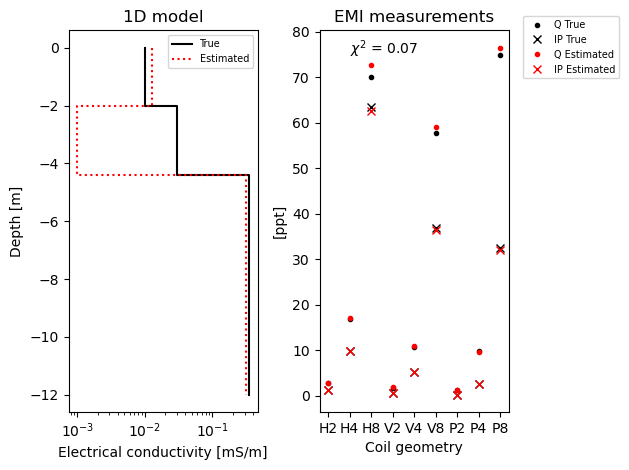

In [9]:
# Plot Models

def PlotModelData(model, depths, data, ax=None, model_name='', model_style='k', data_style='b', data_name=''):
    if ax is None:
        fig, ax = plt.subplots(1,2)
    fs=7
    ax[0].step(model, depths, model_style, label=model_name)
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Electrical conductivity [mS/m]')
    ax[0].set_ylabel('Depth [m]')
    ax[0].legend(fontsize=fs)
    ax[0].set_title('1D model')

    ax[1].plot(data[:9]*1000, '.',c=data_style, label='Q '+data_name)
    ax[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax[1].set_xticklabels(['H2', 'H4', 'H8', 'V2', 'V4', 'V8', 'P2', 'P4', 'P8'])
    ax[1].plot(data[9:]*1000, 'x', c=data_style, label = 'IP '+data_name)
    ax[1].set_xlabel('Coil geometry')
    ax[1].legend(fontsize=fs, bbox_to_anchor=(1.05, 1.05))
    ax[1].set_title('EMI measurements')
    ax[1].set_ylabel('[ppt]')

    plt.tight_layout()

def rmse(y_obs, y_pred):
    L2 = np.sqrt(np.sum(((y_obs-y_pred)/y_obs)**2))
    return L2
    
dmax = -12
sigma_3Lay_true_plot = np.hstack((model_3Lay_true[:3], model_3Lay_true[2]))
depths_3Lay_true_plot = np.array([0, -h1, -h1-h2, dmax])

sigma_3Lay_est_plot = np.hstack((model_3Lay_est[:3], model_3Lay_est[2]))
depths_3Lay_est_plot = np.array([0, -model_3Lay_est[3], -model_3Lay_est[3]-model_3Lay_est[4], dmax])

fig, ax = plt.subplots(1,2)

PlotModelData(sigma_3Lay_true_plot, depths_3Lay_true_plot, data_3Lay_true, model_name='True', data_name='True',
             ax=ax, data_style='k')
PlotModelData(sigma_3Lay_est_plot, depths_3Lay_true_plot, data_3Lay_est, model_name='Estimated', 
              data_name='Estimated', ax=ax, model_style=':r', data_style='r')
ax[1].text(1, 75, '$\chi^2$ = '+ "{:1.2f}".format(rmse(data_3Lay_true, data_3Lay_est)))

plt.savefig('figures/3Lay_Model.eps', format='eps')

In [10]:
def NoiseAnalysis_3Lay(data_true, noise=0.1, test_it=100):
    
    data_noise = []
    for i in range(test_it):
        data_noise.append(data_true* (1 +np.random.normal(size=len(data_true))*noise))

    models = Parallel(n_jobs=n_workers,verbose=0)(delayed(GlobalSearch_3Lay)(LU_3Lay, 
                    data, conds, thicks, nsl) for data in data_noise)
    return models
        
models_noise = NoiseAnalysis_3Lay(data_3Lay_true)

16/04/24 - 01:42:17 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


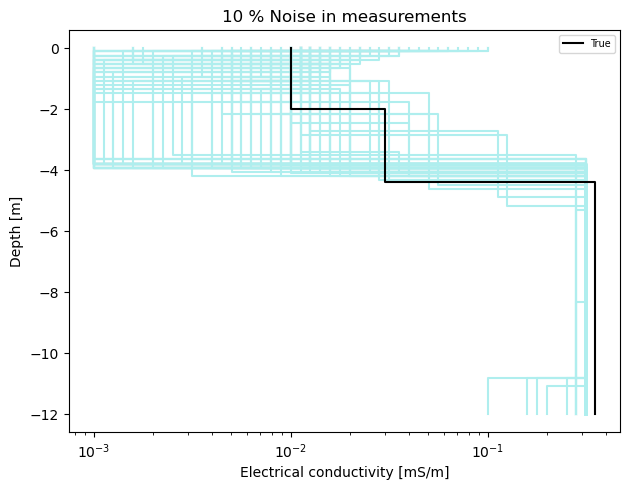

In [11]:
# Plot the models

def PlotModel(model, depths, ax=None, model_name=None, model_style='k'):
    if ax is None:
        fig, ax = plt.subplots()
    fs=7
    ax.step(model, depths, model_style, label=model_name)
    ax.set_xscale('log')
    ax.set_xlabel('Electrical conductivity [mS/m]')
    ax.set_ylabel('Depth [m]')
    if model_name is not None:
        ax.legend(fontsize=fs)
    plt.tight_layout()

fig, ax = plt.subplots()

for m in range(len(models_noise)):
    mod = models_noise[m]
    sigma_3Lay_plot = np.hstack((mod[:3], mod[2]))
    depths_3Lay_plot = np.array([0, -mod[3], -mod[3]-mod[4], dmax])
    PlotModel(sigma_3Lay_plot, depths_3Lay_plot, ax=ax, model_style='paleturquoise')
PlotModel(sigma_3Lay_true_plot, depths_3Lay_true_plot, model_name='True', ax=ax)

plt.title('10 % Noise in measurements') 
plt.savefig('figures/3Lay_Noise.eps', format='eps')

### Gradient descent inversion

It's also possible to analise the possibility of obtaining the estimated model through a gradient descent inversion

In [12]:
# Initialize the forward modelling class 
EMf = EMf_3Lay_Opt_HVP(lambd, height, offsets, freq, filt)

# Define inversion framework from pygimli
invEM = pg.Inversion()
invEM.setForwardOperator(EMf) # set forward operator

transModel = pg.trans.TransLogLU(0.01,3) 
invEM.modelTrans = transModel

# Relative error array
error = 1e-3 # relative error
relativeError = np.ones_like(data_3Lay_true) * error

# Start inversion
model_3Lay_est_gd = invEM.run(data_3Lay_true, relativeError, verbose=False)

# Data from estimated model
data_3Lay_est_gd = EMf_3Lay_HVP(lambd, 
                             sigma1 = model_3Lay_est_gd[0],
                             sigma2 = model_3Lay_est_gd[1],
                             sigma3 = model_3Lay_est_gd[2],
                             h1 = model_3Lay_est_gd[3],
                             h2 = model_3Lay_est_gd[4],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

16/04/24 - 01:42:23 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000


16/04/24 - 01:42:27 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


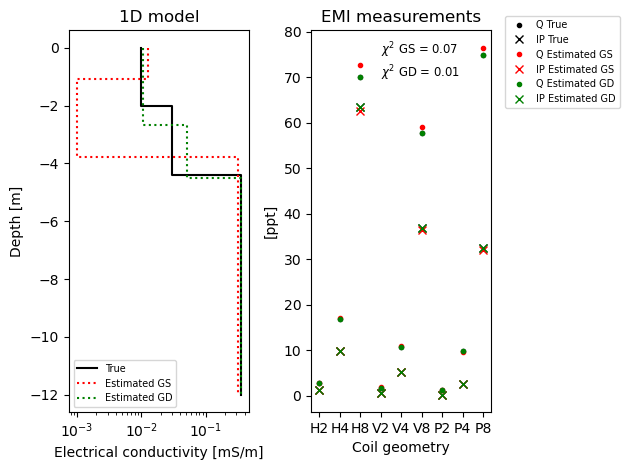

In [13]:
sigma_3Lay_est_gd_plot = np.hstack((model_3Lay_est_gd[:3], model_3Lay_est_gd[2]))
depths_3Lay_est_gd_plot = np.array([0, -model_3Lay_est_gd[3], -model_3Lay_est_gd[3] -model_3Lay_est_gd[4],dmax])

fig, ax = plt.subplots(1,2)

PlotModelData(sigma_3Lay_true_plot, depths_3Lay_true_plot, data_3Lay_true, model_name='True', data_name='True',
             ax=ax, data_style='k')
PlotModelData(sigma_3Lay_est_plot, depths_3Lay_est_plot, data_3Lay_est, model_name='Estimated GS', 
              data_name='Estimated GS', ax=ax, model_style=':r', data_style='r')
PlotModelData(sigma_3Lay_est_gd_plot, depths_3Lay_est_gd_plot, data_3Lay_est_gd, model_name='Estimated GD', 
              data_name='Estimated GD', ax=ax, model_style=':g', data_style='g')

ax[1].text(3, 75, '$\chi^2$ GS = '+ "{:1.2f}".format(rmse(data_3Lay_true, data_3Lay_est)), fontsize='small')
ax[1].text(3, 70, '$\chi^2$ GD = '+ "{:1.2f}".format(rmse(data_3Lay_true, data_3Lay_est_gd)), fontsize='small')

plt.savefig('figures/3Lay_Model_GS_GD.eps', format='eps')

In [14]:
def NoiseAnalysis_3Lay_GD(data_true, noise=0.1, test_it=100):
    
    models = []
    for i in range(test_it):
        data_noise = data_true* (1 +np.random.normal(size=len(data_true))*noise)
        
        # Initialize the forward modelling class 
        EMf = EMf_3Lay_Opt_HVP(lambd, height, offsets, freq, filt)

        # Define inversion framework from pygimli
        invEM = pg.Inversion()
        invEM.setForwardOperator(EMf) # set forward operator

        transModel = pg.trans.TransLogLU(0.01,3) 
        invEM.modelTrans = transModel

        # Relative error array
        error = 1e-3 # relative error
        relativeError = np.ones_like(data_true[0]) * error

        # Start inversion
        models.append(invEM.run(data_noise, relativeError, verbose=False))

    return models
        
models_noise = NoiseAnalysis_3Lay_GD(data_3Lay_true)

16/04/24 - 01:42:36 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000
16/04/24 - 01:42:36 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000
16/04/24 - 01:42:36 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000
16/04/24 - 01:42:36 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000
16/04/24 - 01:42:36 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000
16/04/24 - 01:42:36 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000
16/04/24 - 01:42:36 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000
16/04/24 - 01:42:36 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000
16/04/24 - 01:42:36 - pyGIMLi - INFO - Created startmodel from forward operator: 5, min/max=0.050000/2.000000
16/04/24 -

16/04/24 - 01:42:49 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


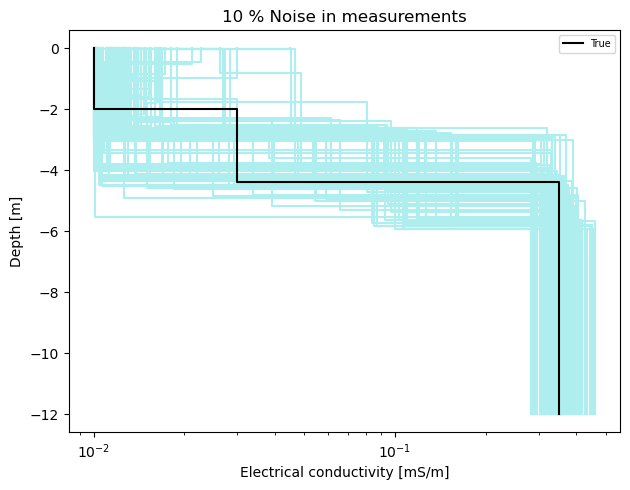

In [15]:
fig, ax = plt.subplots()

for m in range(len(models_noise)):
    mod = models_noise[m]
    sigma_3Lay_plot = np.hstack((mod[:3], mod[2]))
    depths_3Lay_plot = np.array([0, -mod[3], -mod[3]-mod[4], dmax])
    PlotModel(sigma_3Lay_plot, depths_3Lay_plot, ax=ax, model_style='paleturquoise')
PlotModel(sigma_3Lay_true_plot, depths_3Lay_true_plot, model_name='True', ax=ax)

plt.title('10 % Noise in measurements') 
plt.savefig('figures/3Lay_Noise_GD.eps', format='eps')

### Analysis error space

In [16]:
# search the error space and output models with error < 0.1

def ErrorSpace_3Lay(m_est, data_true, conds, thicks, max_err=0.1):
    # Evaluate only conductivity and thickness of middle layer
    
    err = []
    models_below_err = []
    
    for c2 in conds:
        for t1 in thicks: 
            for t2 in thicks:
                m = [m_est[0], c2, m_est[2], t1, t2]
                data_est_pos = EMf_3Lay_HVP(lambd = lambd,
                                            sigma1=m_est[0],
                                            sigma2=c2,
                                            sigma3=m_est[2],
                                            h1=t1,
                                            h2=t2, 
                                            height=height,
                                            offsets=offsets,
                                            freq=freq,
                                            filt=filt) 
                diff = np.abs((data_true - data_est_pos)/data_true)
                merr = np.sum(diff)/len(data_true)

                if merr < max_err:
                    err.append(merr)       
                    models_below_err.append(m)
    
    return models_below_err, err
    
models_err, err = ErrorSpace_3Lay(model_3Lay_est, data_3Lay_true, conds, thicks)

In [17]:
models_err = np.array(models_err)
error = np.array(error)

def PlotErrorSpace(model, model_est, err, models_err, depthmax=10):
      
    fig, axs = plt.subplots()
    
    x = models_err[:,4] # thickness of 2 layer
    y = models_err[:,3] # thickness of 1 layer
    z = err
    
    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
        
    #ax1 = fig.add_subplot(1,3,2)
    
    my_cmap = copy.copy(matplotlib.cm.get_cmap("RdBu_r")) # copy the default cmap
    my_cmap.set_bad('w')

    axs.contour(xi, yi, zi*100, levels=14, linewidths=0.5, colors='k', )
    cntr1 = axs.contourf(xi, yi, zi*100, levels=14, cmap=my_cmap)
    axs.plot(x, y, '.k', ms=1)
    axs.set(xlim=(2.5,3), ylim=(0.5,1.5))
    axs.scatter(model_est[4], model_est[3],
                 marker ='^', c='y', label='Estimated model')
    axs.set_xlabel('$h_2$ [m]', fontsize=8)
    axs.set_ylabel('$h_1$ [m]', fontsize=8)
    axs.legend(fontsize=8)
    axs.tick_params(axis='both',labelsize=8)
    
    x = models_err[:,1]*1000  # resistivity of second
    y = models_err[:,3] # thickness of 1 layer
   
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    #ax2 = fig.add_subplot(1,3,3, sharey=ax1)

   # axs[1].contour(xi, yi, zi*100, levels=14, linewidths=0.5, colors='k')
   # cntr1 = axs.contourf(xi, yi, zi*100, levels=14, cmap=my_cmap)
   # axs[1].plot(x, y, '.k', ms=1)
    #ax2.set(xlim=(0.05,0.1), ylim=(2,3))
   # axs[1].scatter(model_est[1]*1000, model_est[3],
   #              marker ='^', c='y', label='Estimated model')
   # axs[1].set_xlabel('$\sigma_2$ [mS/m]', fontsize=8)
   # axs[1].legend(fontsize=8)
   # xticks = np.linspace(0.050, 0.1, 3)
   # xlabels = [50, 75, 100]
   # axs[1].set_xticks(xticks, labels=xlabels,)
   # axs[1].tick_params(axis='both',labelsize=8)
    #ax0.tick_params(axis='both',labelsize=8)
    clb = fig.colorbar(cntr1, ax=axs)
    clb.ax.set_title('RMSE %', fontsize=8)
    clb.ax.tick_params(labelsize=8)

/tmp/ipykernel_849732/1676789217.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = copy.copy(matplotlib.cm.get_cmap("RdBu_r")) # copy the default cmap
16/04/24 - 01:43:29 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


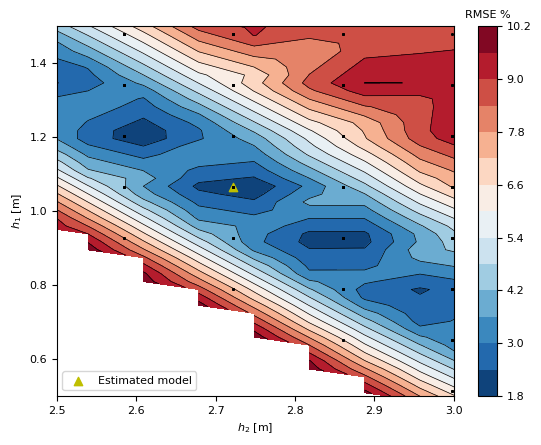

In [18]:
PlotErrorSpace(model_3Lay_true, model_3Lay_est, err, models_err)

plt.savefig('figures/3Lay_ErrorSpace.eps', format='eps')